# Contingency Analysis in Transmission Grids

Contingency analysis is a critical process in power system operations used to assess the impact of potential failures (e.g., line outages) on grid stability and reliability. It helps operators prepare for unexpected events by simulating scenarios such as N-1 or N-2 contingencies, where one or more components are removed from service. This analysis ensures that the grid can continue to operate within safe limits even under stressed conditions.

---

## Dataset Generation and Model Evaluation

The dataset used in this study originates from the Texas transmission grid, which includes approximately 2,000 nodes. Using the contingency mode of the `gridfm-datakit`, we simulated N-2 contingencies by removing up to two transmission lines at a time. For each scenario, we first solved the optimal power flow (OPF) problem to determine the generation dispatch. Then, we applied the contingency by removing lines and re-solved the power flow to observe the resulting grid state.

This process generated around 100,000 unique scenarios. Our model, **GridFMv0.1**, was fine-tuned on this dataset to predict power flow outcomes. For demonstration purposes, we selected a subsample of 10 scenarios. The `gridfm-datakit` also computed DC power flow results, enabling a comparison between GridFMv0.1 predictions and traditional DC power flow estimates, specifically in terms of line loading accuracy.

All predictions are benchmarked against the ground truth obtained from AC power flow simulations. Additionally, we analyze bus voltage violations, which GridFM can predict but are not captured by the DC solver, highlighting GridFM’s enhanced capabilities in modeling grid behavior.



In [ ]:
from gridfm_graphkit.datasets.postprocessing import (
    compute_branch_currents_kA,
    compute_loading,
)
from gridfm_graphkit.datasets.postprocessing import create_admittance_matrix
from gridfm_graphkit.utils.utils import compute_cm_metrics
from gridfm_graphkit.utils.visualization import (
    plot_mass_correlation_density,
    plot_cm,
    plot_loading_predictions,
    plot_mass_correlation_density_voltage,
)

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys

if "google.colab" in sys.modules:
    try:
        !git clone https://github.com/gridfm/gridfm-graphkit.git
        %cd /content/gridfm-graphkit
        !pip install -e .
        !pip install -e .[dev,test]
    except Exception as e:
        print(f"Failed to start Google Collab setup, due to {e}")

## Load Data

We load both the ground truth and predicted values of the power flow solution. The predictions are generated using the `gridfm-graphkit` CLI:

```bash
gridfm-graphkit predict ...
```

We then merge the datasets using `scenario` and `bus` as keys, allowing us to align the predicted and actual values for each grid state and bus.

In [70]:
root_pred_folder = "../data/contingency_texas/"
prediction_dir = "prediction_gridfm01"
label_plot = "GridFM_v0.1 Fine-tuned"

In [71]:
pf_node_GT = pd.read_csv(os.path.join(root_pred_folder, "pf_node_10_examples.csv"))
pg_node_predicted = pd.read_csv(
    os.path.join(root_pred_folder, "predictions_10_examples.csv")
)

branch_idx_removed = pd.read_csv("{}branch_idx_removed.csv".format(root_pred_folder))
edge_params = pd.read_csv("{}edge_params.csv".format(root_pred_folder))
bus_params = pd.read_csv("{}bus_params.csv".format(root_pred_folder))

In [72]:
pf_node = pg_node_predicted.merge(pf_node_GT, on=["scenario", "bus"], how="left")
pf_node.head()

,scenario,bus,PD_pred,QD_pred,PG_pred,QG_pred,VM_pred,VA_pred,Pd,Qd,Pg,Qg,Vm,Va,PQ,PV,REF,Vm_dc,Va_dc
0,6665,0,289.88303,386.46190,-269.17026,95.973550,0.973004,-23.517038,17.641483,4.849515,0.00,0.000000,0.973382,-23.651456,1.0,0.0,0.0,1.000000,-18.540175
1,6665,1,399.95087,111.63771,380.59073,-19.526617,1.027900,-16.083895,12.862669,3.603862,0.00,0.000000,1.028113,-16.356100,1.0,0.0,0.0,1.000000,-10.642648
2,6665,2,418.41193,336.66327,372.41583,-16.310265,0.982477,-15.997509,0.000000,0.000000,0.00,0.000000,0.982483,-16.219837,1.0,0.0,0.0,1.000000,-11.845012
3,6665,3,541.56036,361.17136,260.12170,-6.565100,0.994687,-17.817055,0.000000,0.000000,158.25,-6.701038,0.989999,-18.047683,0.0,1.0,0.0,0.989999,-13.627838
4,6665,4,535.40500,315.90330,378.09350,10.435824,1.005842,-13.160706,0.000000,0.000000,0.00,0.000000,1.005977,-13.327186,1.0,0.0,0.0,1.000000,-7.870087


## Create Admittance matrix

In [73]:
sn_mva = 100
Yf, Yt, Vf_base_kV, Vt_base_kV = create_admittance_matrix(
    bus_params, edge_params, sn_mva
)
rate_a = edge_params["rate_a"].values

## Correct voltage predictions for GridFM and DC

In [74]:
pf_node["Vm_pred_corrected"] = pf_node["VM_pred"]
pf_node["Va_pred_corrected"] = pf_node["VA_pred"]

pf_node.loc[pf_node.PV == 1, "Vm_pred_corrected"] = pf_node.loc[pf_node.PV == 1, "Vm"]
pf_node.loc[pf_node.REF == 1, "Va_pred_corrected"] = pf_node.loc[pf_node.REF == 1, "Va"]

pf_node["Vm_dc_corrected"] = pf_node["Vm_dc"]
pf_node["Va_dc_corrected"] = pf_node["Va_dc"]

pf_node.loc[pf_node.PV == 1, "Vm_dc_corrected"] = pf_node.loc[pf_node.PV == 1, "Vm"]
pf_node.loc[pf_node.REF == 1, "Va_dc_corrected"] = pf_node.loc[pf_node.REF == 1, "Va"]

## Compute branch current and line loading

In [75]:
loadings = []
loadings_pred = []
loadings_dc = []

for scenario_idx in tqdm(pf_node.scenario.unique()):
    pf_node_scenario = pf_node[pf_node.scenario == scenario_idx]
    branch_idx_removed_scenario = (
        branch_idx_removed[branch_idx_removed.scenario == scenario_idx]
        .iloc[:, 1:]
        .values
    )
    # remove nan
    branch_idx_removed_scenario = branch_idx_removed_scenario[
        ~np.isnan(branch_idx_removed_scenario)
    ].astype(np.int32)
    V_true = pf_node_scenario["Vm"].values * np.exp(
        1j * pf_node_scenario["Va"].values * np.pi / 180
    )
    V_pred = pf_node_scenario["Vm_pred_corrected"].values * np.exp(
        1j * pf_node_scenario["Va_pred_corrected"].values * np.pi / 180
    )
    V_dc = pf_node_scenario["Vm_dc_corrected"].values * np.exp(
        1j * pf_node_scenario["Va_dc_corrected"].values * np.pi / 180
    )
    If_true, It_true = compute_branch_currents_kA(
        Yf, Yt, V_true, Vf_base_kV, Vt_base_kV, sn_mva
    )
    If_pred, It_pred = compute_branch_currents_kA(
        Yf, Yt, V_pred, Vf_base_kV, Vt_base_kV, sn_mva
    )
    If_dc, It_dc = compute_branch_currents_kA(
        Yf, Yt, V_dc, Vf_base_kV, Vt_base_kV, sn_mva
    )

    loading_true = compute_loading(If_true, It_true, Vf_base_kV, Vt_base_kV, rate_a)
    loading_pred = compute_loading(If_pred, It_pred, Vf_base_kV, Vt_base_kV, rate_a)
    loading_dc = compute_loading(If_dc, It_dc, Vf_base_kV, Vt_base_kV, rate_a)

    # remove the branches that are removed from loading
    loading_true[branch_idx_removed_scenario] = -1
    loading_pred[branch_idx_removed_scenario] = -1
    loading_dc[branch_idx_removed_scenario] = -1

    loadings.append(loading_true)
    loadings_pred.append(loading_pred)
    loadings_dc.append(loading_dc)


loadings = np.array(loadings)
loadings_pred = np.array(loadings_pred)
loadings_dc = np.array(loadings_dc)

100%|██████████| 10/10 [00:00<00:00, 5000.36it/s]


In [76]:
removed_lines = loadings == -1
removed_lines_pred = loadings_pred == -1
removed_lines_dc = loadings_dc == -1


# assert the same lines are removed
assert (removed_lines == removed_lines_pred).all()
assert (removed_lines == removed_lines_dc).all()

# assert the same number of lines are removed
assert removed_lines.sum() == removed_lines_pred.sum()
assert removed_lines.sum() == removed_lines_dc.sum()

In [77]:
overloadings = loadings[removed_lines == False] > 1.0
overloadings_pred = loadings_pred[removed_lines == False] > 1.0
overloadings_dc = loadings_dc[removed_lines == False] > 1.0

## Compute metrics for overloading classification for GridFM and DC PF
- Below are the results of GridFM for overloading classification (GNN version, not transformer, finetuned on PF for IEEE300, and later finetuned on Contingency Data)
- Ground truth is AC PF.

In [78]:
TP_gridfm, FP_gridfm, TN_gridfm, FN_gridfm = compute_cm_metrics(
    overloadings, overloadings_pred, prediction_dir, label_plot
)

Accuracy: 0.991
Confusion Matrix:
TP: 4753, FP: 150, TN: 27126, FN: 154
GridFM
TPR: 0.969 (percentage of overloadings correctly predicted)
FPR: 0.005 (percentage of non-overloadings predicted as overloadings)
TNR: 0.99
FNR: 0.03


- Below are the results of DC PF for overloading classification
- Ground truth is AC PF.
- We use a threshold of 0.95 to make sure we identify all overloads

In [79]:
TP_dc, FP_dc, TN_dc, FN_dc = compute_cm_metrics(
    overloadings, overloadings_dc, "DC", label_plot
)

Accuracy: 0.960
Confusion Matrix:
TP: 4113, FP: 505, TN: 26771, FN: 794
GridFM
TPR: 0.838 (percentage of overloadings correctly predicted)
FPR: 0.019 (percentage of non-overloadings predicted as overloadings)
TNR: 0.98
FNR: 0.16


## Histogram of true line loadings



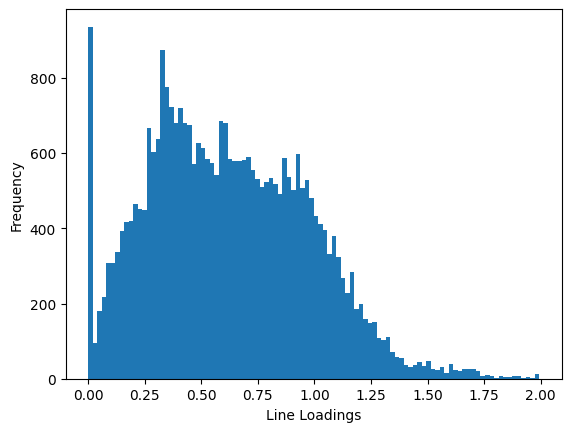

In [80]:
plt.hist(loadings[removed_lines == False], bins=100)
plt.xlabel("Line Loadings")
plt.ylabel("Frequency")
# log scale
plt.savefig(f"loadings_histogram_{prediction_dir}.png")
plt.show()

## Predicted vs True line loading

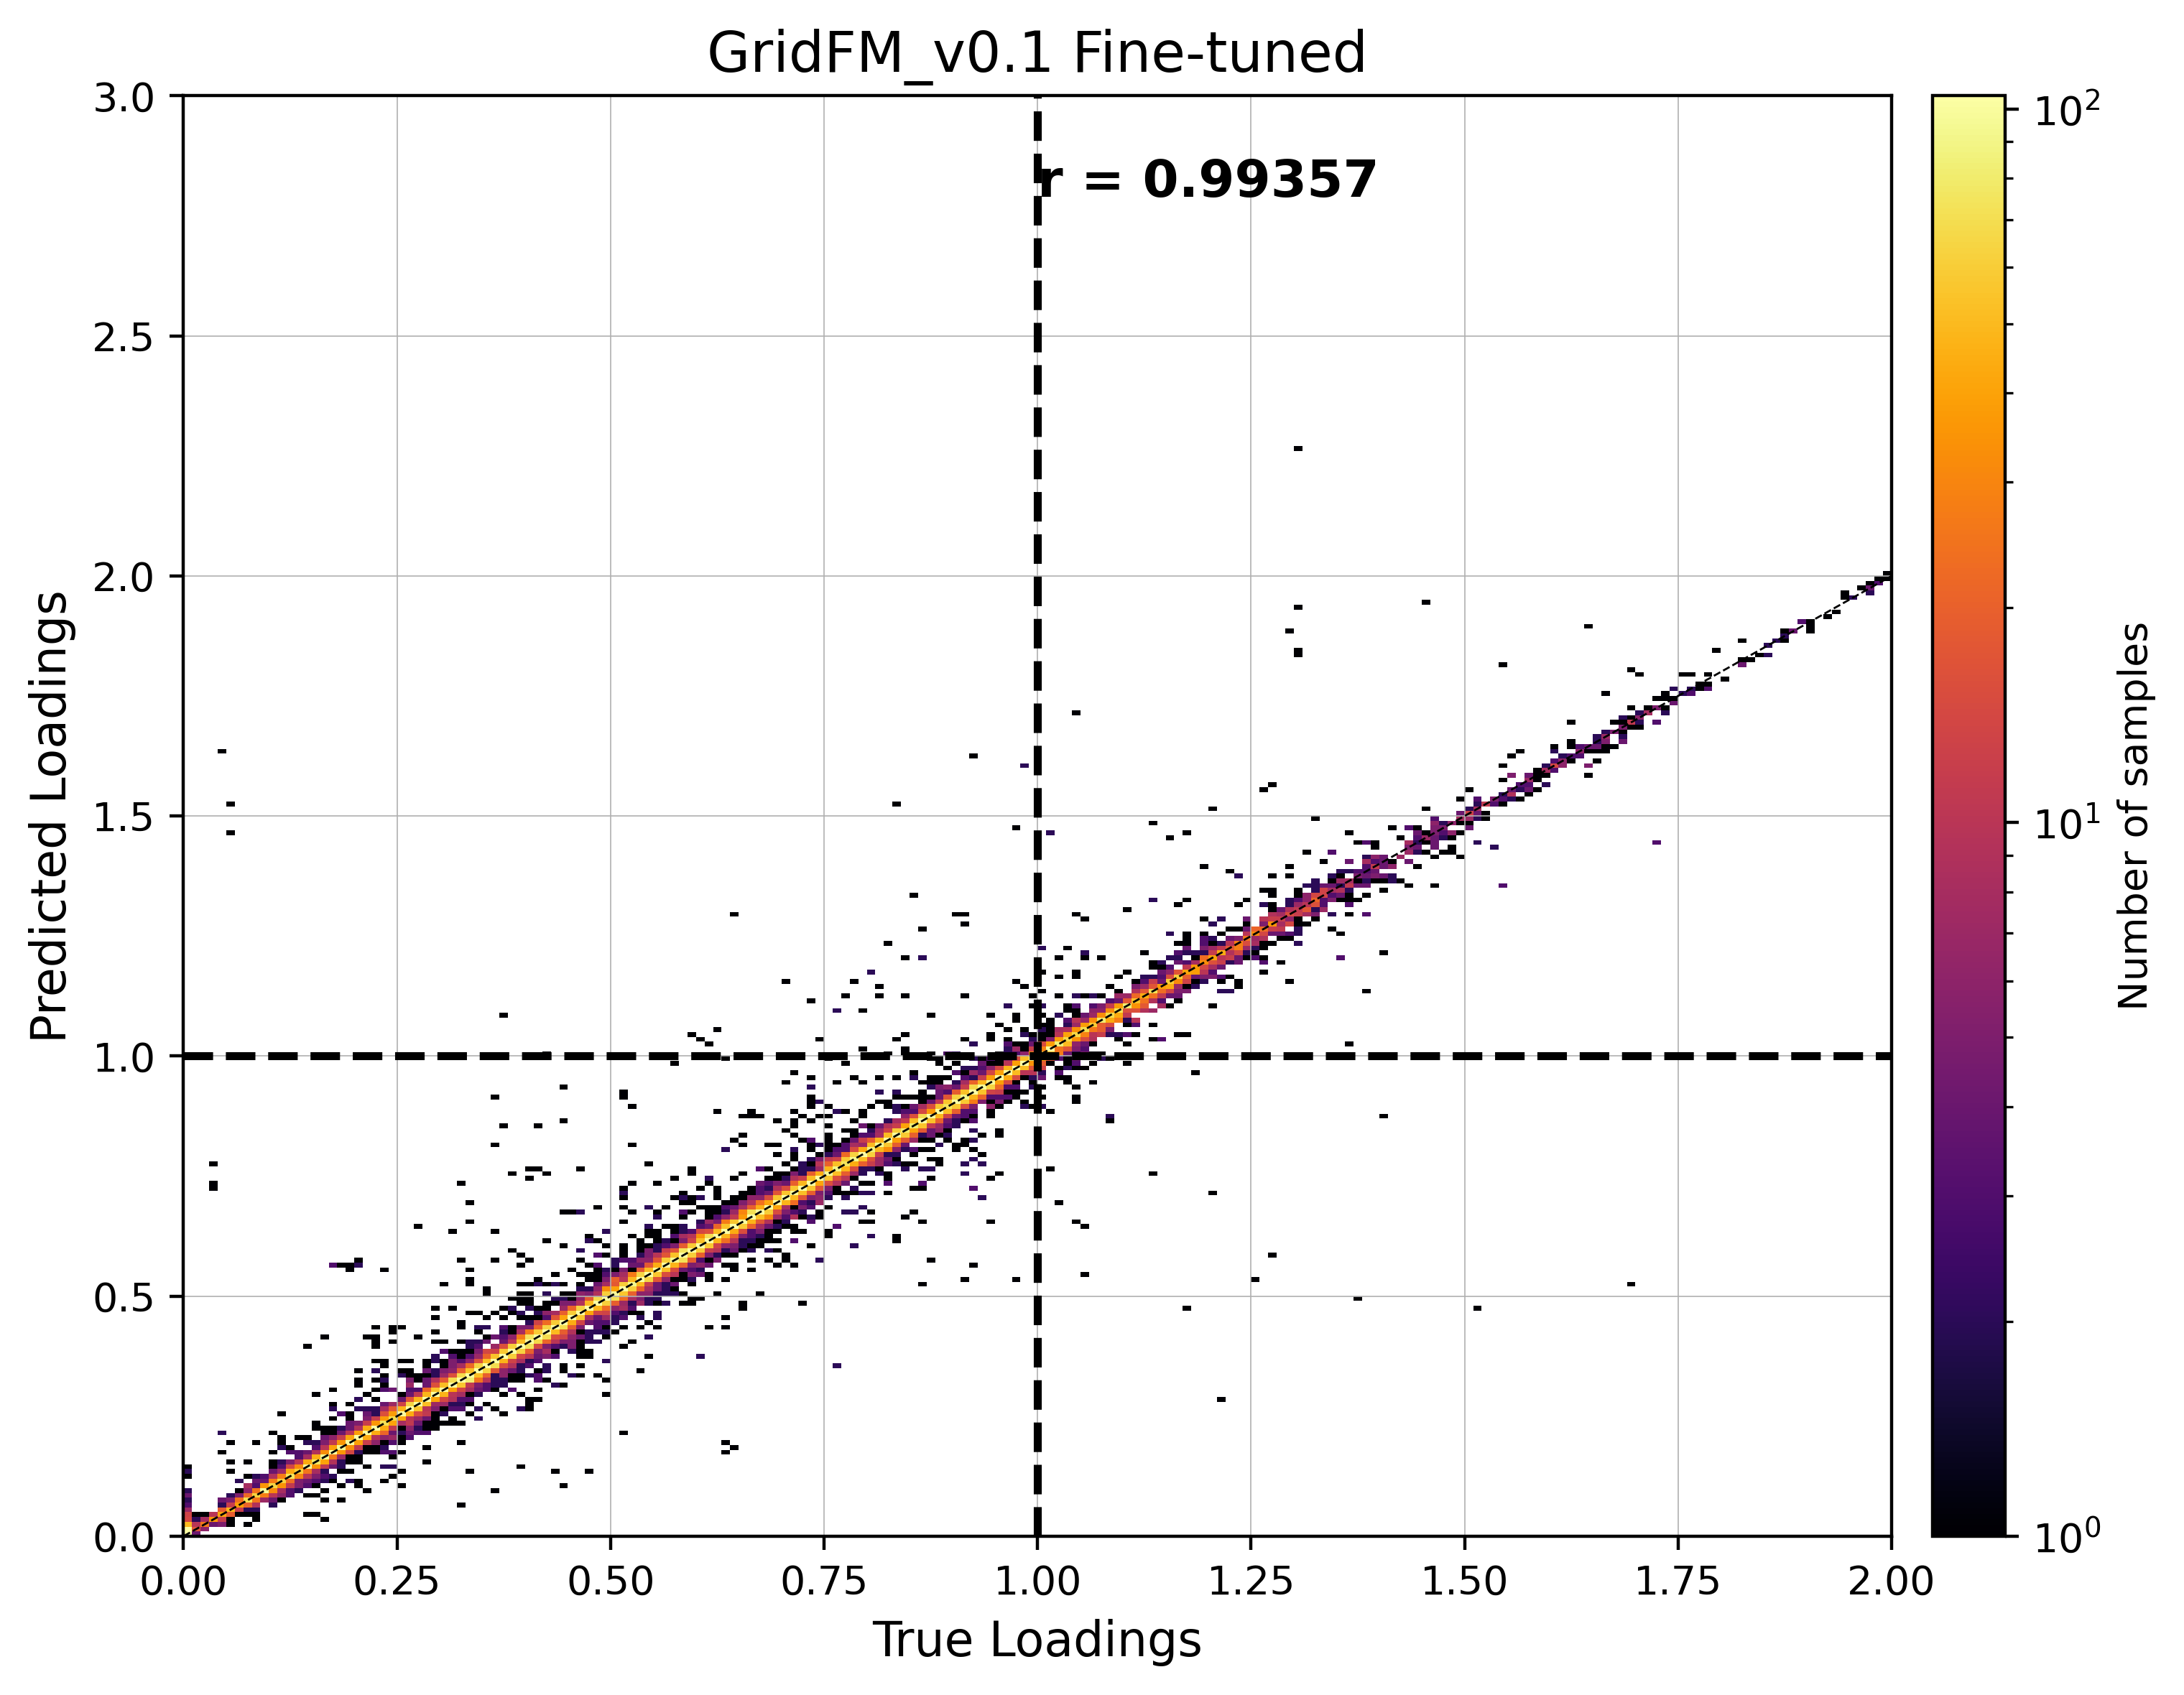

In [81]:
# Valid lines
valid_mask = removed_lines == False

# Extract valid values
true_vals = loadings[valid_mask]
gfm_vals = loadings_pred[valid_mask]
dc_vals = loadings_dc[valid_mask]

plot_mass_correlation_density(true_vals, gfm_vals, prediction_dir, label_plot)

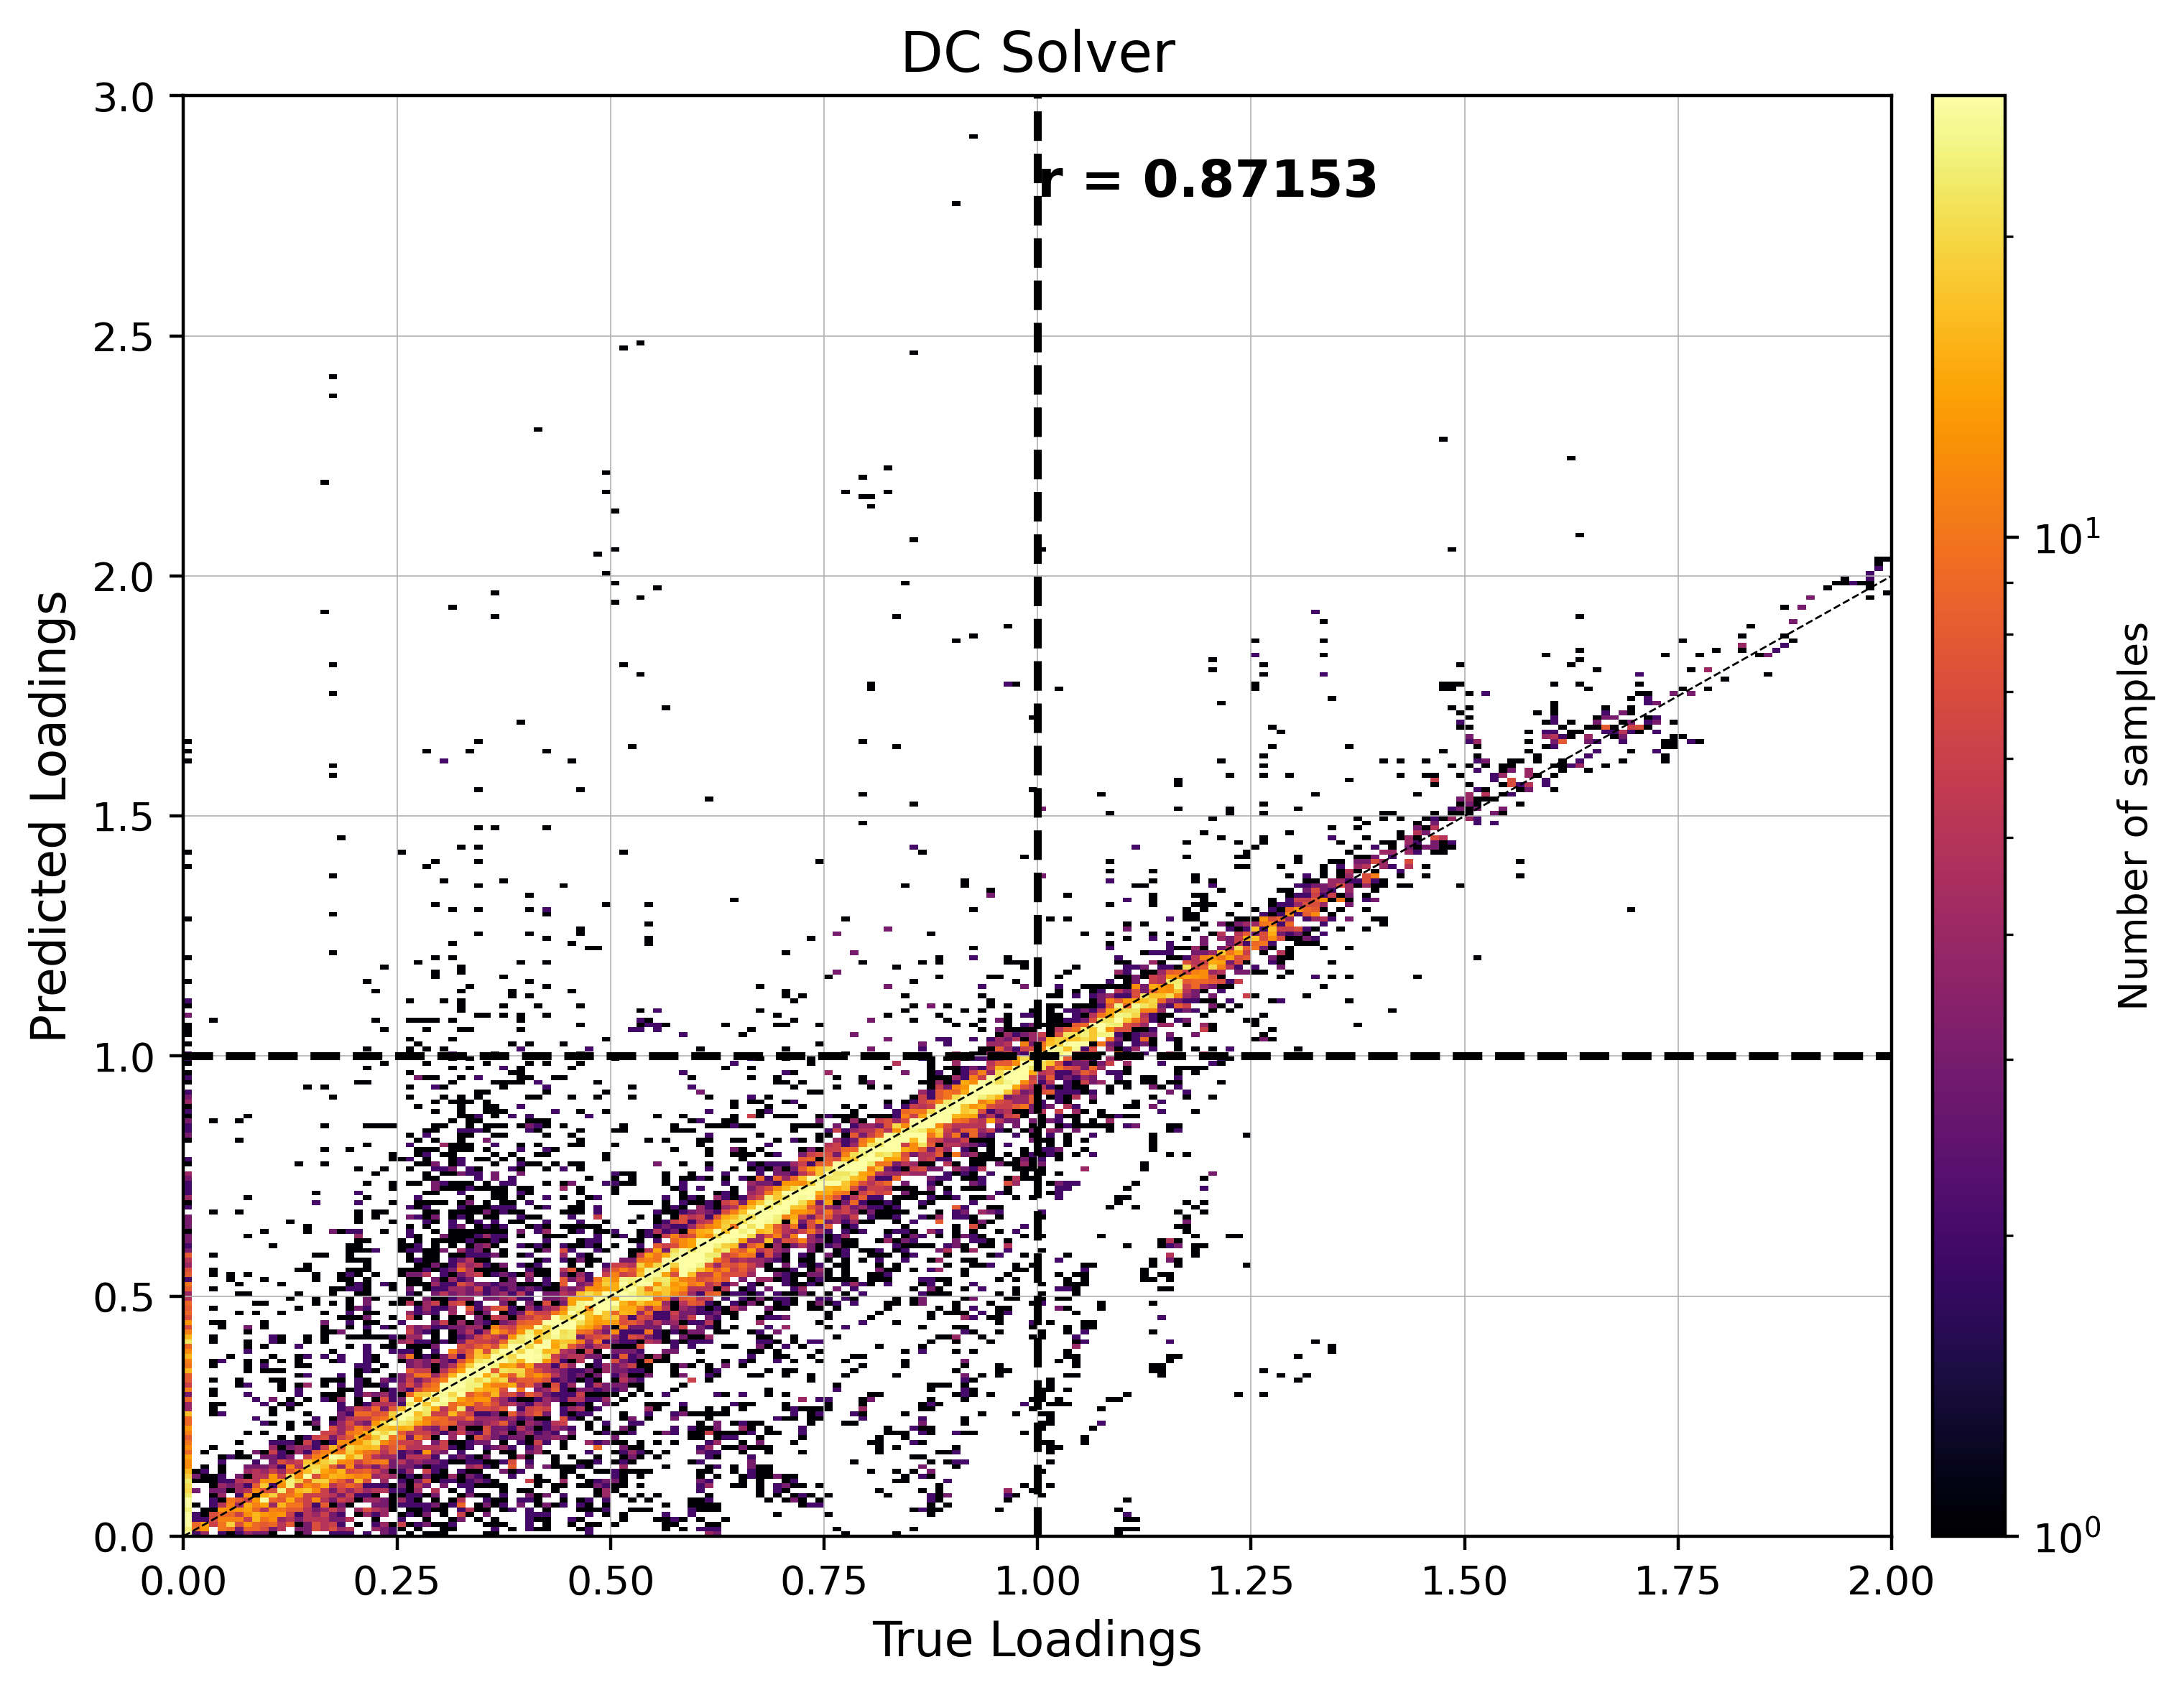

In [82]:
plot_mass_correlation_density(true_vals, dc_vals, "DC", "DC Solver")

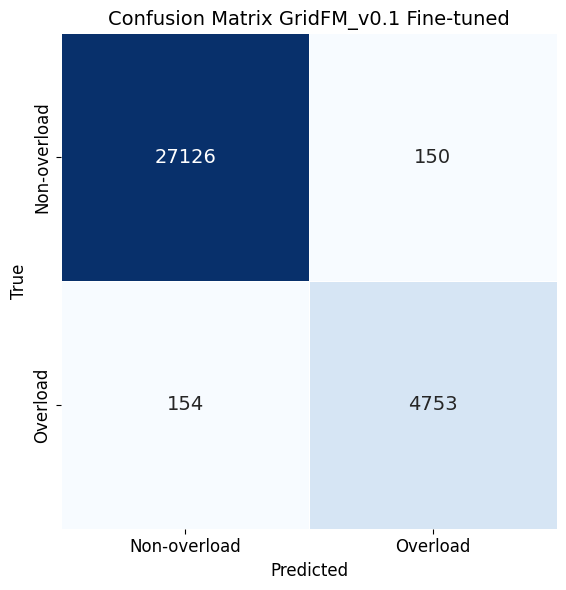

In [83]:
plot_cm(TN_gridfm, FP_gridfm, FN_gridfm, TP_gridfm, prediction_dir, label_plot)

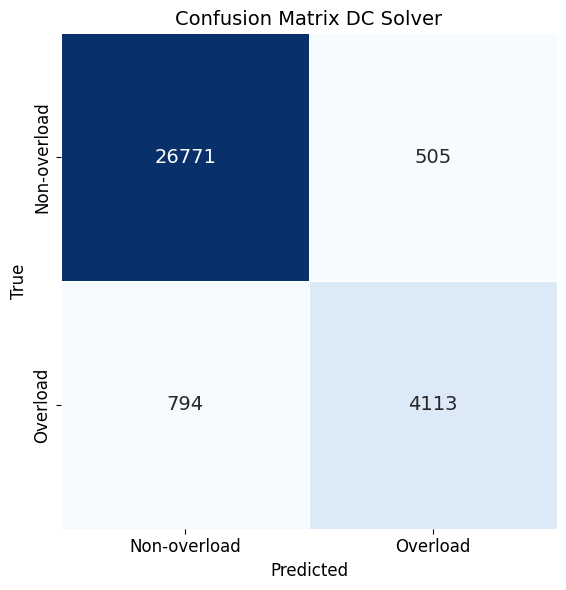

In [84]:
plot_cm(TN_dc, FP_dc, FN_dc, TP_dc, "DC", "DC Solver")

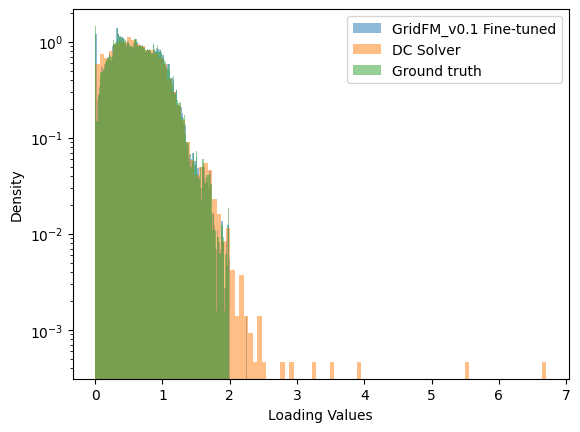

In [85]:
# Histograms of loadings
plot_loading_predictions(
    loadings_pred[removed_lines == False],
    loadings_dc[removed_lines == False],
    loadings[removed_lines == False],
    prediction_dir,
    label_plot,
)

In [86]:
# create df from loadings
loadings_df = pd.DataFrame(loadings)
loadings_df.columns = [f"branch_{i}" for i in range(loadings_df.shape[1])]

loadings_pred_df = pd.DataFrame(loadings_pred)
loadings_pred_df.columns = [f"branch_{i}" for i in range(loadings_pred_df.shape[1])]

In [87]:
loadings_df["scenario"] = pf_node["scenario"].unique()
loadings_pred_df["scenario"] = pf_node["scenario"].unique()

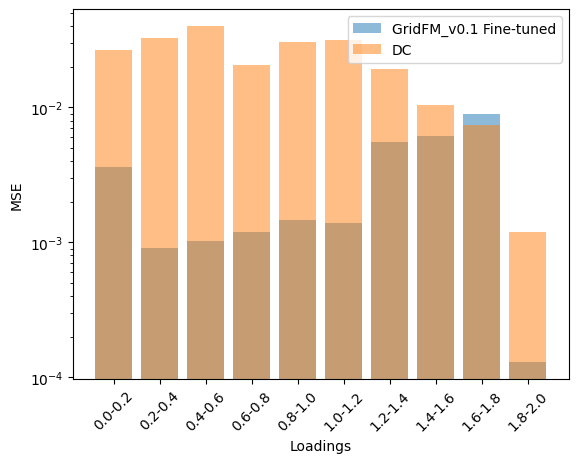

In [88]:
# make bar plot of wrongly classified loadings for different bins
bins = np.arange(0, 2.2, 0.2)
mse_pred = []
mse_dc = []
for i in range(len(bins) - 1):
    idx_in_bins = (loadings[removed_lines == False] > bins[i]) & (
        loadings[removed_lines == False] < bins[i + 1]
    )
    mse_pred.append(
        np.mean(
            (
                loadings_pred[removed_lines == False][idx_in_bins]
                - loadings[removed_lines == False][idx_in_bins]
            )
            ** 2
        )
    )
    mse_dc.append(
        np.mean(
            (
                loadings_dc[removed_lines == False][idx_in_bins]
                - loadings[removed_lines == False][idx_in_bins]
            )
            ** 2
        )
    )


# labels
labels = [f"{bins[i]:.1f}-{bins[i + 1]:.1f}" for i in range(len(bins) - 1)]
plt.bar(labels, mse_pred, label=label_plot, alpha=0.5)
plt.bar(labels, mse_dc, label="DC", alpha=0.5)
plt.legend()
plt.xlabel("Loadings")
plt.ylabel("MSE")
# y log scale
plt.yscale("log")
# rotate x labels
plt.xticks(rotation=45)
plt.savefig(f"loading_mse_{prediction_dir}.png")
plt.show()

## Voltage violations

In [89]:
# merge bus_params["vmax"] and bus_params["vmin"] with pf_node on bus_idx
pf_node = pd.merge(pf_node, bus_params[["bus", "vmax", "vmin"]], on="bus", how="left")

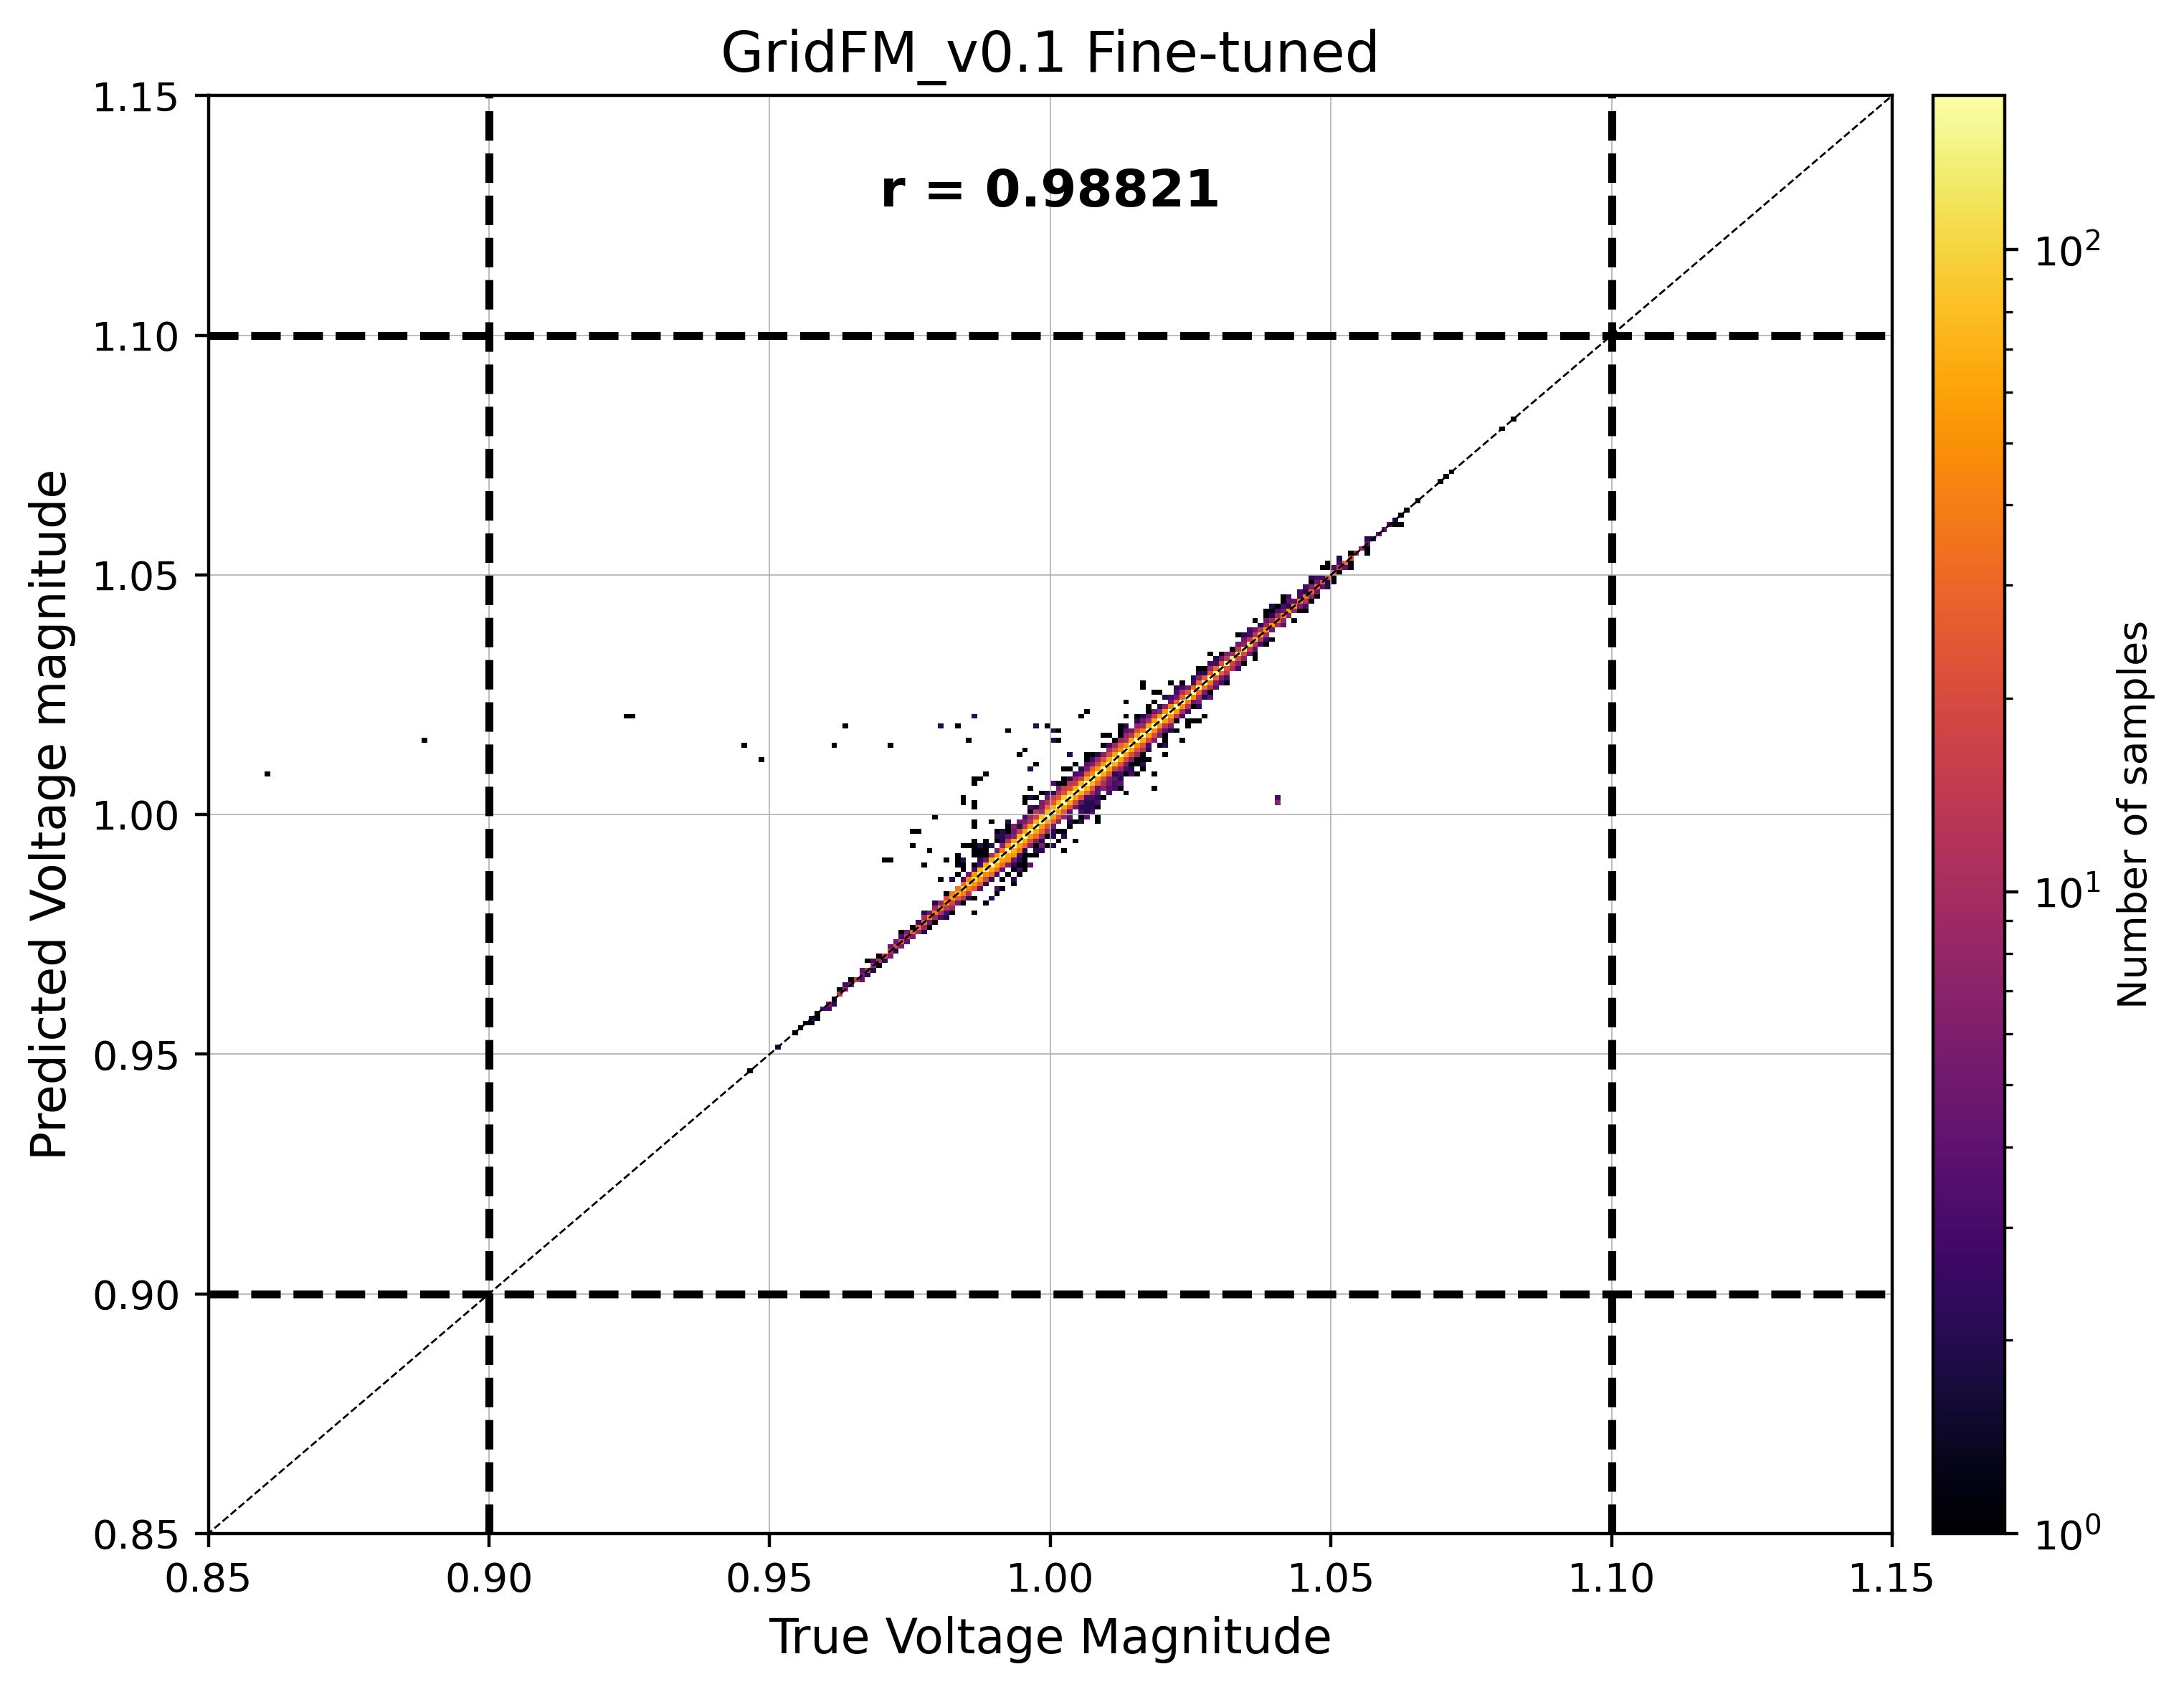

In [90]:
plot_mass_correlation_density_voltage(pf_node, prediction_dir, label_plot)